In [2109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

# Lecture des données

In [2110]:
################# lecture des donées ######################
csv_files = glob.glob("C:/Users/TRETEC/Desktop/DARI project/transactions-ser/*.csv")
data=pd.DataFrame()
L=[]
for f in csv_files:    
    L.append(pd.read_csv(f,sep=";"))
data=pd.concat(L)
###########################################################

# Exploration des données
## Analyse de la forme des donnés
* Target variable : valeur_fonciere
* lignes et colonnes : (2972, 41)
* type de variables : object:30, float64:7, int64:4
* données manquantes : presque la moitié des variables ont >90% de NaN

## Data cleaning
* Retirer les données avec beaucoup de NaN
* Puisque on travail que sur les données de saint-étienne-du-rouvray supprimer les colonnes qui ont une valeur unique : communes, département ... 
* Supprimer les colonnes redondantes : code_nature_culture (redondant à nature_culture), code_type_local (redondant à type local) ...

## Analyse approfondi des données
* valeur target: la majorité des biens ont une valeur foncière entre 10 000-500 000€. Beacoup de valeurs sont très faibles (exp:1€). il existe aussi une valeur très élevé 36M€.
* variables continu : surface_reel_bati sont symétrique non normalisé, surface_terrain données non symétriques
* variables discrètes : nombre de pièces ~80% entre 3-5 pièces. type_local ~3/4 sont de maisons. Nature_culture sont majoritairement des sols. exemple equi probable sur les différents secteur

## Relation entre les variables
#### Relation entres les variables et target
* Pour les maisons, il existe une forte corrélation positif entre la valeur fiscale et nombre de pièce, la surface bati, la surface du terrain ce qui est complétement cohérent
* Pour ce qui est des appartement il y a une correlation négatif entre la valeur fiscale et nombre de pièce, la surface bati, la surface du terrain ce qui est contre intuitif est laisse un gros doute quant à la fiabilités des données pour les appartement

In [2111]:
pd.options.display.max_columns = 41
pd.options.display.max_rows = 2972

In [2112]:
df=data.copy()
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
0,2022-360375,2022-04-21,1,Vente,260000.0,26.0,None,RUE DELILLE,582,76800,76575,Saint-Étienne-du-Rouvray,76,None,None,76575000AB0065,None,None,None,None,None,None,None,None,None,None,None,None,0,1,Maison,129.0,4.0,S,sols,None,None,351.0,1.071855,49.401886,000AB
1,2022-360375,2022-04-21,1,Vente,260000.0,26.0,None,RUE DELILLE,582,76800,76575,Saint-Étienne-du-Rouvray,76,None,None,76575000AB0065,None,None,None,None,None,None,None,None,None,None,None,None,0,3,Dépendance,NaN,0.0,S,sols,None,None,351.0,1.071855,49.401886,000AB
2,2021-1180016,2021-05-10,1,Vente,160000.0,13.0,None,RUE ALFRED DE MUSSET,40,76800,76575,Saint-Étienne-du-Rouvray,76,None,None,76575000AB0023,None,None,None,None,None,None,None,None,None,None,None,None,0,1,Maison,64.0,4.0,S,sols,None,None,452.0,1.070963,49.402764,000AB
3,2021-1177880,2021-01-14,1,Vente,174000.0,21.0,None,RUE PAUL VERLAINE,1920,76800,76575,Saint-Étienne-du-Rouvray,76,None,None,76575000AB0012,None,None,None,None,None,None,None,None,None,None,None,None,0,1,Maison,64.0,4.0,S,sols,None,None,498.0,1.070475,49.403622,000AB
4,2021-1177880,2021-01-14,1,Vente,174000.0,21.0,None,RUE PAUL VERLAINE,1920,76800,76575,Saint-Étienne-du-Rouvray,76,None,None,76575000AB0012,None,None,None,None,None,None,None,None,None,None,None,None,0,3,Dépendance,NaN,0.0,S,sols,None,None,498.0,1.070475,49.403622,000AB


In [2113]:
df.shape

(2972, 41)

In [2114]:
df.dtypes.value_counts()

object     30
float64     7
int64       4
dtype: int64

In [2115]:
df.dtypes

id_mutation                      object
date_mutation                    object
numero_disposition                int64
nature_mutation                  object
valeur_fonciere                 float64
adresse_numero                  float64
adresse_suffixe                  object
adresse_nom_voie                 object
adresse_code_voie                object
code_postal                      object
code_commune                      int64
nom_commune                      object
code_departement                  int64
ancien_code_commune              object
ancien_nom_commune               object
id_parcelle                      object
ancien_id_parcelle               object
numero_volume                    object
lot1_numero                      object
lot1_surface_carrez              object
lot2_numero                      object
lot2_surface_carrez              object
lot3_numero                      object
lot3_surface_carrez              object
lot4_numero                      object


<AxesSubplot:>

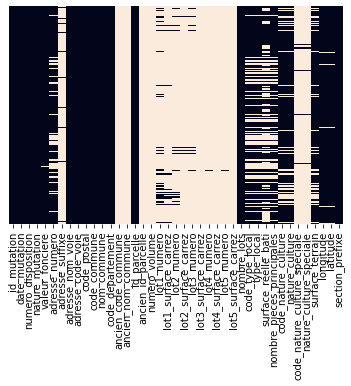

In [2116]:
df.replace('None',np.nan,inplace=True)
sns.heatmap(df.isna(),cbar=False,xticklabels=True, yticklabels=False)

In [2117]:
(df.isna().sum()/df.shape[0]).sort_values()

id_mutation                     0.000000
nombre_lots                     0.000000
id_parcelle                     0.000000
code_departement                0.000000
nom_commune                     0.000000
code_commune                    0.000000
section_prefixe                 0.000000
date_mutation                   0.000000
numero_disposition              0.000000
nature_mutation                 0.000000
adresse_nom_voie                0.005047
code_postal                     0.005047
adresse_code_voie               0.005047
longitude                       0.009085
latitude                        0.009085
valeur_fonciere                 0.016824
surface_terrain                 0.153769
code_nature_culture             0.153769
nature_culture                  0.153769
adresse_numero                  0.163190
code_type_local                 0.260094
type_local                      0.260094
nombre_pieces_principales       0.260767
surface_reelle_bati             0.457268
lot1_numero     

# Traitement des données

### Suppressions des exemple qui ne sont pas des maisons ou des appartement (local industriel, local commercial, dépendance)

In [2118]:
df.type_local.unique()

array(['Maison', 'Dépendance', 'Appartement',
       'Local industriel. commercial ou assimilé', nan], dtype=object)

In [2119]:
df = df.loc[(df.type_local != 'Local industriel. commercial ou assimilé') & (df.type_local != 'Dépendance') & (df.nature_culture != "Terrain à bâtir")]

### Suppression les colonnes inutiles

In [2120]:
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.84]] # retirer les données avec beaucoup de NaN
# supprimer les colonnes qui ont une valeur unique : communes, département ... puisque on travail que sur les données de saint-étienne-du-rouvray
df = df.drop(['code_departement','nom_commune','code_commune','code_postal'],axis=1)
# supprimer les colonnes redondantes : code_nature_culture (redondant à nature_culture), code_type_local (redondant à type local) ...
df = df.drop(['code_nature_culture','code_type_local','adresse_code_voie'],axis=1)
# supprimer les colonnes liées à la transaction (id_mutation, numéro_disposition, nature_mutation ...)
df = df.drop(['id_mutation','numero_disposition','id_parcelle','date_mutation','nature_mutation'],axis=1)
# incompréhension de la variable nature_culture, il est préférable de la retiré du moment que la signification de cette variable nous ai inconnu
df = df.drop('nature_culture',axis=1)

### Problème de la surface terrain pour les appartement
comme nous pouvons le voir il n'y a aucune correlation entre la surface du terrain et la valeur des appartement. Il serait préférable d'ignorer la surface du terrain pour tous les appartement.

Cela nous permetterait d'une part de retirer une variable qui risque de biaiser les résultats. D'autre part, cela nous permetterait d'augmenter le nombre d'exemple d'appartement (avant suppression des données manquantes) cat nous avons beaucoup de valeurs manquantes concernant la surface des terrain pour les appartement

Text(0.5, 1.0, 'surface terrain vs target (Appartements)')

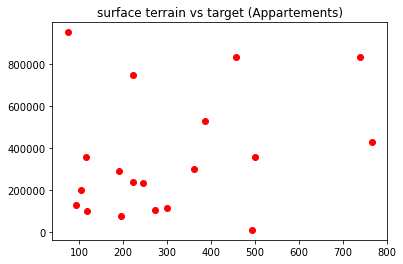

In [2121]:
df_terrain_appartement = df.loc[df.type_local == "Appartement"]
df_terrain_appartement = df_terrain_appartement.groupby("surface_terrain").mean().valeur_fonciere
plt.figure()
plt.scatter(df_terrain_appartement[df_terrain_appartement.index < 1000].index,df_terrain_appartement[df_terrain_appartement.index < 1000],color='red')
plt.title("surface terrain vs target (Appartements)")

Pour ignorer la variable surface terrain pour les appartement nous allons remplacer ses valeur par 0

In [2122]:
df.loc[df.type_local == 'Appartement','surface_terrain'] = 0

### Problème des erreurs sur les valeurs foncières
Il existe des valeur foncière très proches de la valeurs 0 (voir graphe ci-dessous), ce qui est impossible. Ces données risque de nous causer un biais sur la partie d'apprentissage, il est préférable de les retirer des données

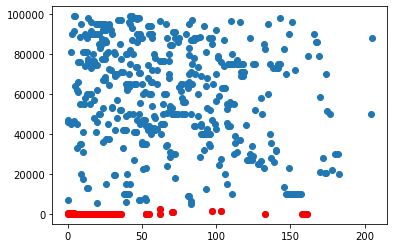

In [2123]:
plt.figure()
plt.scatter(df[df.valeur_fonciere<100000].index,df[df.valeur_fonciere<100000].valeur_fonciere)
plt.scatter(df[df.valeur_fonciere<4000].index,df[df.valeur_fonciere<4000].valeur_fonciere,color='red')

In [2124]:
df = df[df.valeur_fonciere>4000]

In [2125]:
(df.isna().sum()/df.shape[0]).sort_values()

valeur_fonciere              0.000000
nombre_lots                  0.000000
section_prefixe              0.000000
longitude                    0.005311
latitude                     0.005311
adresse_nom_voie             0.007435
surface_terrain              0.013277
adresse_numero               0.107807
type_local                   0.235263
surface_reelle_bati          0.235263
nombre_pieces_principales    0.235263
dtype: float64

In [2126]:
##################################################### Drop NA ##################################################
df = df.dropna()
################################################################################################################
df.shape

(1429, 11)

## Anlyse en profondeur des données
### Etudier la structure des donnés continues

C:\Users\TRETEC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\TRETEC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\TRETEC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

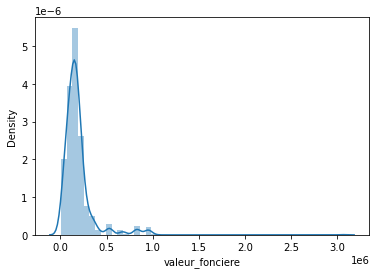

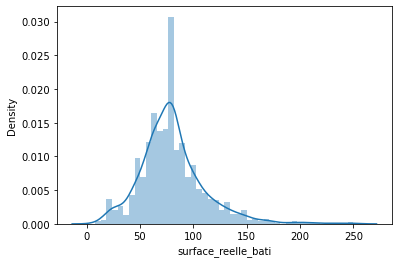

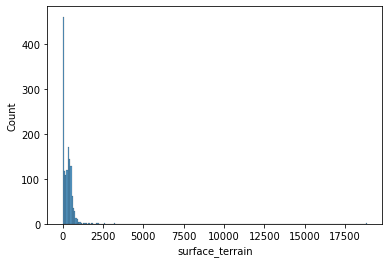

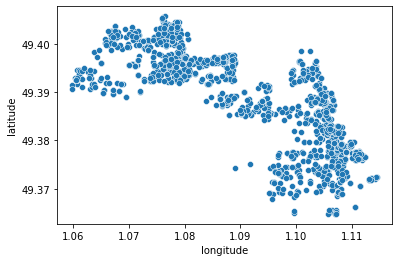

In [2127]:
#for col in df.select_dtypes('float'):
#    print(col)

plt.figure()
sns.distplot(df.loc[(df.valeur_fonciere < 36855776.00) & (df.valeur_fonciere > 1000)].valeur_fonciere)


plt.figure()
sns.distplot(df['surface_reelle_bati'])

plt.figure()
sns.histplot(df['surface_terrain'])

plt.figure()
sns.scatterplot(df['longitude'],df['latitude'])



### Etudier la structure des données Discrètes

In [2128]:
#for col in df.select_dtypes('object'):
#    print(col)
L=["nombre_pieces_principales","type_local","section_prefixe","nombre_lots"]
for col in L:
    print(f"{col: <30}{df[col].unique()}")

nombre_pieces_principales     [ 4.  1.  5.  3.  2.  7.  6.  8. 22.]
type_local                    ['Maison' 'Appartement']
section_prefixe               ['000AB' '000AC' '000AD' '000AE' '000AI' '000AK' '000AO' '000AP' '000AR'
 '000AS' '000AT' '000AV' '000AW' '000AX' '000AY' '000AZ' '000BC' '000BD'
 '000BE' '000BH' '000BK' '000BL' '000BM' '000BO' '000BP' '000BR' '000BS'
 '000BT' '000BV' '000BW']
nombre_lots                   [0 3 2 1]


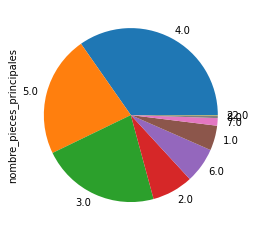

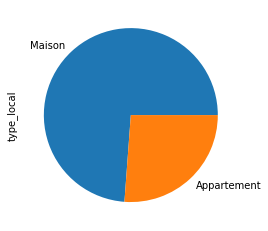

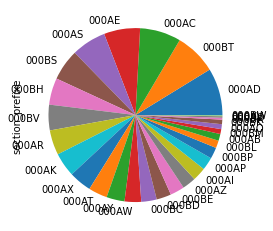

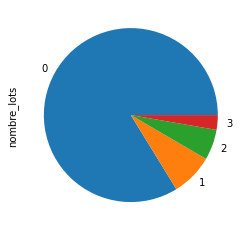

In [2129]:
for col in L:
    plt.figure()
    df[col].value_counts().plot.pie()

# Relation entre les variables et target

#### Pièce principales

Text(0.5, 1.0, 'Nombre de pièces principal vs target (Appartements)')

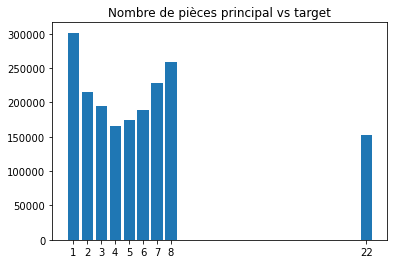

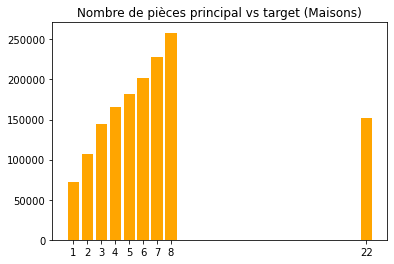

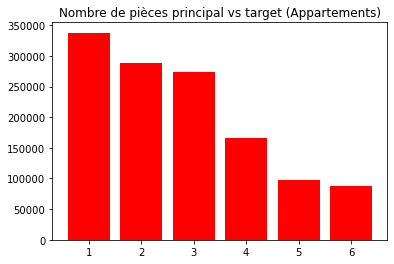

In [2130]:
df_piece=df.groupby("nombre_pieces_principales").mean().valeur_fonciere
df_piece
plt.figure()
plt.bar(df_piece.index,df_piece)
plt.xticks(df_piece.index)
plt.title("Nombre de pièces principal vs target")

df_piece_maison = df.loc[df.type_local == "Maison"]
df_piece_maison = df_piece_maison.groupby("nombre_pieces_principales").mean().valeur_fonciere
plt.figure()
plt.bar(df_piece_maison.index,df_piece_maison,color='orange')
plt.xticks(df_piece_maison.index)
plt.title("Nombre de pièces principal vs target (Maisons)")

df_piece_appartement = df.loc[df.type_local == "Appartement"]
df_piece_appartement = df_piece_appartement.groupby("nombre_pieces_principales").mean().valeur_fonciere
plt.figure()
plt.bar(df_piece_appartement.index,df_piece_appartement,color='red')
plt.xticks(df_piece_appartement.index)
plt.title("Nombre de pièces principal vs target (Appartements)")


#### Type local

<BarContainer object of 2 artists>

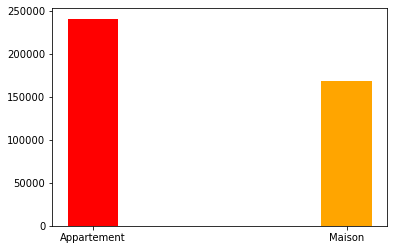

In [2131]:
df_type_local=df.groupby("type_local").mean().valeur_fonciere
df_type_local
plt.figure()
plt.bar(df_type_local.index,df_type_local,color=['red','orange'],width=0.2)

#### Surface terrain

Text(0.5, 1.0, 'surface terrain vs target (Maison)')

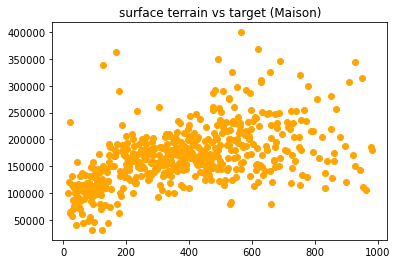

In [2132]:
df_terrain_maison = df.loc[df.type_local == "Maison"]
df_terrain_maison = df_terrain_maison.groupby("surface_terrain").mean().valeur_fonciere
plt.figure()
plt.scatter(df_terrain_maison[df_terrain_maison.index < 1000].index,df_terrain_maison[df_terrain_maison.index < 1000],color='orange')
plt.title("surface terrain vs target (Maison)")

#### Surface bati

Text(0.5, 1.0, 'surface bati vs target (Appartements)')

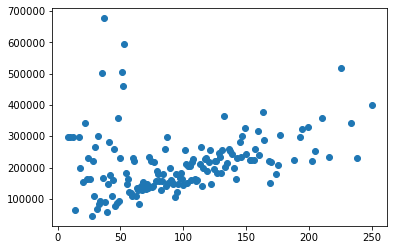

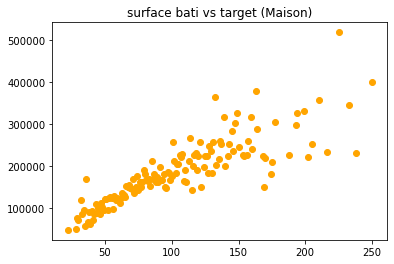

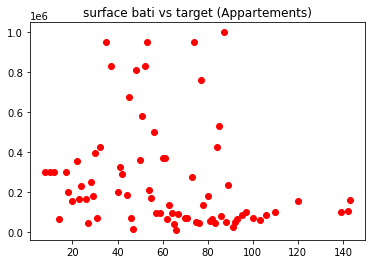

In [2133]:
df_surface_bati=df.groupby("surface_reelle_bati").mean().valeur_fonciere
plt.figure()
plt.scatter(df_surface_bati.index,df_surface_bati)

df_bati_maison = df.loc[df.type_local == "Maison"]
df_bati_maison = df_bati_maison.groupby("surface_reelle_bati").mean().valeur_fonciere
plt.figure()
plt.scatter(df_bati_maison[df_bati_maison.index < 2000].index,df_bati_maison[df_bati_maison.index < 2000],color='orange')
plt.title("surface bati vs target (Maison)")

df_bati_appartement = df.loc[df.type_local == "Appartement"]
df_bati_appartement = df_bati_appartement.groupby("surface_reelle_bati").mean().valeur_fonciere
plt.figure()
plt.scatter(df_bati_appartement.index,df_bati_appartement,color='red')
plt.title("surface bati vs target (Appartements)")

#### Secteur/localisation
Il est difficile de trouver une correlation entre section_prefixe/section_prefixe et la valeur fonciere car au sein de chaque section_prefixe/adresse_nom_voie la valeur des bien varie énormément, car comme nous l'avons vu la valeur a une très forte corrélation avec d'autre variable (surface, nbr_piece).

<BarContainer object of 188 artists>

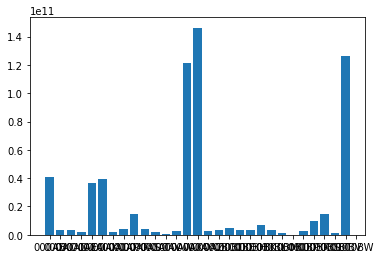

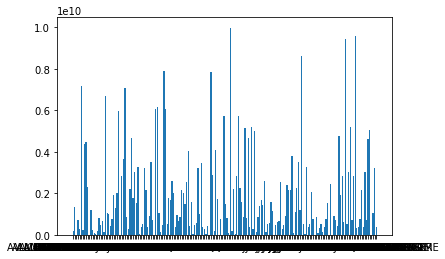

In [2134]:
df_section=df.groupby("section_prefixe").var().valeur_fonciere
plt.figure()
plt.bar(df_section.index,df_section)
plt.xticks()

df_nbr_lot=df.groupby("adresse_nom_voie").var().valeur_fonciere
plt.figure()
plt.bar(df_nbr_lot[df_nbr_lot < 10000000000].index,df_nbr_lot[df_nbr_lot < 10000000000])

## Correlation entre les variables
### variable de secteur, adresse, et géolocalisation
Il est évident qu'il existe une correlation très forte entre les adresse (num rue + nom rue) et les coordonnée GPS (longitude + latitude). Cependant, lorsqu'on pense à l'experience utilisateur, il est préférable de demander le nom de la rue par exemple plus tôt que les coordonnées GPS.

L'application va permettre d'estimer la valeurs des appartement et des maisons pour des acheteurs et des vendeurs, il est donc important de garder la localisation du bien ni trop spécifique (en incluant le numéro de la rue par exemple) ni trop vague. Les deux candidats pour décrire le mieux le positionnement du bien sont donc : adresse_nom_voie et section_prefixe.

Nous devons sélectionné une de ces deux variables pour éviter la redandance étant donné que les deux variables sont très corrélés. A cet étape il est difficile d'en choisir une seule variable, nous allons faire des test avec les deux variables durant la partie apprentissage et garder la variable qui donne le meuilleur modèle.

In [2135]:
df = df.drop(['latitude','longitude','nombre_lots','adresse_numero'],axis=1)

### Autres variables
#### Biens de type maison

<AxesSubplot:>

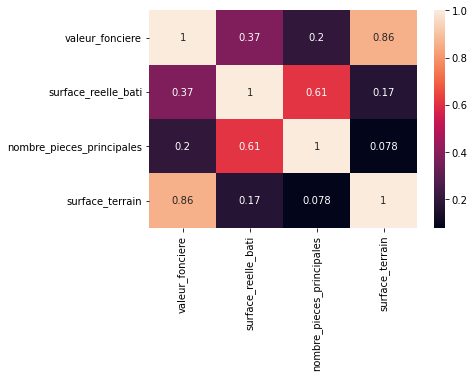

In [2136]:
sns.heatmap(df[df.type_local == 'Maison'].corr(),annot=True)

#### Biens de type appartement

<AxesSubplot:>

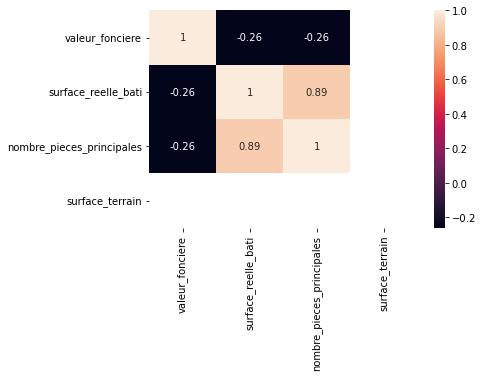

In [2137]:
sns.heatmap(df[df.type_local == 'Appartement'].corr(),annot=True)

## Coder les varibales de catégorie

In [2138]:
df["type_local"] = df["type_local"].astype('category')
df["type_local_cat"] = df["type_local"].cat.codes

df["section_prefixe"] = df["section_prefixe"].astype('category')
df["section_prefixe_cat"] = df["section_prefixe"].cat.codes

df["adresse_nom_voie"] = df["adresse_nom_voie"].astype('category')
df["adresse_nom_voie_cat"] = df["adresse_nom_voie"].cat.codes

In [2108]:
df.head()

,valeur_fonciere,adresse_nom_voie,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,section_prefixe
0,260000.0,RUE DELILLE,Maison,129.0,4.0,351.0,000AB
2,160000.0,RUE ALFRED DE MUSSET,Maison,64.0,4.0,452.0,000AB
3,174000.0,RUE PAUL VERLAINE,Maison,64.0,4.0,498.0,000AB
5,200000.0,RUE DU MADRILLET,Appartement,18.0,1.0,0.0,000AB
7,180000.0,RUE DELILLE,Maison,108.0,5.0,348.0,000AB


In [1765]:
clean_df = df.copy()
clean_df = clean_df.drop(['adresse_nom_voie','type_local','section_prefixe'],axis=1)


# Apprentissage

Etant données que les données concernant les appartement sont complétement décorélées, la qualité des prédictions des prix des appartement risque d'être fausse (on confirmera cela suite à nos testes). C'est pour cette raison que nous allons faire un modèle pour les maisons séparément ensuite un autre modèle pour les appartements

## Données Maisons

### Régression linéair

In [2144]:
df_home = clean_df[clean_df.type_local_cat == 1]
df_home = df_home.drop(['type_local_cat','adresse_nom_voie_cat'],axis=1)

In [2145]:
X = df_home.iloc[:,1:].values
y = df_home.iloc[:,0].values

In [2146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [2147]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)
#cross_val_score(regressor, X_train, y_train, cv=5).mean()
regressor.score(X_test,y_test)
print(f"Accuracy : {regressor.score(X_test, y_test)*100:.2f}%")

Accuracy : 62.75%


### Ridge regression

In [1877]:
alpha_range=5000
scores_ridge=np.zeros(alpha_range)
for a in range (0,alpha_range,1):
    rid = Ridge(alpha=a)
    rid.fit(X_train, y_train)
    #prediction = rid.predict(X_test)
    scores_ridge[a]=cross_val_score(rid, X_train, y_train, cv=5).mean()
#print(np.argmax(scores_ridge))
#print(np.max(scores_ridge))
#print(rid.coef_)
a=np.argmax(scores_ridge)
print(a)
rid = Lasso(alpha=a)
rid.fit(X_train, y_train)
print(f"Accuracy : {rid.score(X_test, y_test)*100:.2f}%")

1151
Accuracy : 62.70%


### Lasso regression

In [2148]:
alpha_range=5000
scores_las=np.zeros(alpha_range)
for a in range (1,alpha_range,1):
    las = Lasso(alpha=a)
    las.fit(X_train, y_train)
    #prediction = rid.predict(X_test)
    scores_las[a]=cross_val_score(las, X_train, y_train, cv=5).mean()

a=np.argmax(scores_las)
print(a)
#print(np.max(scores_las))
las = Lasso(alpha=a)
las.fit(X_train, y_train)
print(f"Accuracy : {las.score(X_test, y_test)*100:.2f}%")

3460
Accuracy : 62.74%


### Régression polynomial

In [2149]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
reg_house = LinearRegression()
reg_house.fit(X_train_poly, y_train)
prediction_house = reg_house.predict(X_test_poly)
print(f"Accuracy : {reg_house.score(X_test_poly, y_test)*100:.2f}%")

Accuracy : 71.49%


In [2033]:
A_house=[0.0, 1419.0607130996075, 22003.791769940002, 124.00864832313322, 380.2350752791426, -139.55600657560683, 0.7444790167758355, 10.510936853533687, -27.805205185220355, -164.91108658278432, -0.8445930817257835]
B_house= -26300.862647456146
reg_house.coef_.tolist()

[0.0,
 1419.0607130996075,
 22003.791769940002,
 124.00864832313322,
 380.2350752791426,
 -139.55600657560683,
 0.7444790167758355,
 10.510936853533687,
 -27.805205185220355,
 -164.91108658278432,
 -0.8445930817257835]

In [2034]:
reg_house.intercept_

-26300.862647456146

In [2036]:
def estimation_maison(surface, piece, terrain, section, A, B):
    f= B + A[0]+A[1]*surface+A[2]*piece+A[3]*terrain+A[4]*section + A[5]*surface*piece+A[6]*surface*terrain+A[7]*surface*section + A[8]*piece*terrain+A[9]*piece*section + A[10]*terrain*section
    return f

## Données Appartements

### Régression linéair

In [2150]:
df_appart = clean_df[clean_df.type_local_cat == 0]
df_appart = df_appart.drop(['type_local_cat','adresse_nom_voie_cat','surface_terrain'],axis=1)

In [2151]:
X = df_appart.iloc[:,1:].values
y = df_appart.iloc[:,0].values

In [2152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [2153]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
prediction = lin_reg.predict(X_test)
#cross_val_score(regressor, X_train, y_train, cv=5).mean()
print(f"Accuracy : {lin_reg.score(X_test, y_test)*100:.2f}%")

Accuracy : 32.07%


### Ridge regression

In [1852]:
alpha_range=500000
scores_ridge=np.zeros(alpha_range)
for a in range (1,alpha_range,100):
    rid = Ridge(alpha=a)
    rid.fit(X_train, y_train)
    scores_ridge[a]=cross_val_score(rid, X_train, y_train, cv=5).mean()
a=np.argmax(scores_ridge)
print(a)
rid = Lasso(alpha=a)
rid.fit(X_train, y_train)
print(f"Accuracy : {rid.score(X_test, y_test)*100:.2f}%")

101
Accuracy : 32.07%


### Lasso regression

In [1851]:
alpha_range=500000
scores_las=np.zeros(alpha_range)
for a in range (1,alpha_range,100):
    las = Lasso(alpha=a)
    las.fit(X_train, y_train)
    scores_las[a]=cross_val_score(las, X_train, y_train, cv=5).mean()
a=np.argmax(scores_las)
print(a)
las = Lasso(alpha=a)
las.fit(X_train, y_train)
print(f"Accuracy : {las.score(X_test, y_test)*100:.2f}%")

26101
Accuracy : 31.03%


### Régression polynomial

In [2154]:
poly = PolynomialFeatures(degree=3,interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
reg_appart = LinearRegression()
reg_appart.fit(X_train_poly, y_train)
prediction = reg_appart.predict(X_test_poly)
print(f"Accuracy : {reg_appart.score(X_test_poly, y_test)*100:.2f}%")

Accuracy : 37.07%


Après analyse des résultats nous allons sélectionner les modèles de régressions polynomials de degrée 2 pour les données de maisons et de degré 3 pour les données d'appartements.

Ue taux de précision de plus de 70% pour le modèles de prédiction des prix de maison. Mais seulement 37% de précision sur les prédiction des prix d'appartements, ce qui était prévisible vu la nature des données.

# Extraction des données nécessaire à l'application mobile

## Extraction des encoding des variables textuelles

In [2141]:
df.groupby("type_local").mean().type_local_cat.to_csv('type_local_encoding.csv',index=True)

In [2143]:
df.groupby("section_prefixe").mean().section_prefixe_cat.to_csv('selection_prefixe_encoding.csv',index=True)

### Extraction de l'équation de la droite de rérgression

#### Données Maisons

In [2167]:
f = open("equation_regression_maison.txt", "w")
equa_house=f"A={reg_house.coef_.tolist()}\nB={reg_house.intercept_}\n\nEquation:\nB + A[0]+A[1]*surface+A[2]*piece+A[3]*terrain+A[4]*section + A[5]*surface*piece+A[6]*surface*terrain+A[7]*surface*section + A[8]*piece*terrain+A[9]*piece*section + A[10]*terrain*section"
f.write(equa_house)
f.close()

#### Données Appartement

In [2170]:
f = open("equation_regression_appartement.txt", "w")
equa_appart=f"A={reg_appart.coef_.tolist()}\nB={reg_appart.intercept_}\n\nEquation:\nB + A[0] +A[1]*surface+A[2]*piece+A[3]*section + A[4]*surface*piece+A[5]*surface*section+A[6]*piece*section + A[7]*surface*piece*section"
f.write(equa_appart)
f.close()